## This notebook is for pre-processing liveability factor data TEMP VERSION


### 1. Setting up the coding environment

In [221]:
%reset -f

In [222]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# For the clustering chunk
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram
import spopt
from spopt.region import MaxPHeuristic as MaxP
import libpysal
import warnings
import pysal as ps
import plotly.express as px

### 2. Reading and cleaning data

| Metric | Data | Unit | Year | Link |
| :- | -: | :- | :-: | :- |
| 0_Boundary | Boundary | Ward | 2013 | https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london |
| 1_Transportation | PTAL | Ward | 2013* | https://data.london.gov.uk/dataset/london-ward-well-being-scores |
| 2_Neighbourhood | Green and open space access | Ward | 2013* | (same as above) |
| 3_Opportunity | Average GCSE scores | Ward | 2013* | (same as above) |
| 4_Housing | Median house price | Ward | 2014 | https://data.london.gov.uk/dataset/ward-profiles-and-atlas |
| 0_Population | Population | Ward | 2015* | (same as above) |
| 5_Environment | Pollution impact | Ward | 2008* | https://data.london.gov.uk/dataset/estimation-health-impacts-particulate-pollution-london |
| 6_Safety | Residential bulgarly | Ward | 2009 | https://data.london.gov.uk/dataset/recorded_crime_summary |

In [223]:
# Initialise the dataframe to store all data
df_combined = pd.DataFrame()

#### 0. Boundary (2018)

In [224]:
file = os.path.join('data', 'raw', 'London-wards-2013', 'London_Ward.shp')

boundary = gpd.read_file(file)

<AxesSubplot:>

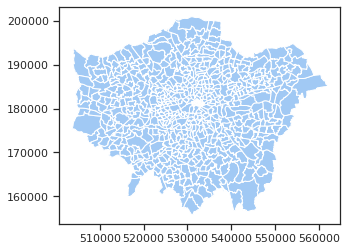

In [225]:
boundary.plot()

In [226]:
boundary.columns

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH',
       'POLY_ID', 'geometry'],
      dtype='object')

In [227]:
# Cleaning up
boundary.drop(['HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'POLY_ID'], axis=1, inplace=True)

In [228]:
boundary.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      649 non-null    object  
 1   GSS_CODE  649 non-null    object  
 2   BOROUGH   649 non-null    object  
 3   geometry  649 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 20.4+ KB


#### 1 & 2 & 3 - from well-being scores

In [229]:
# Reading in the data

file = os.path.join('data', 'raw', 'well_being_data.csv')
cols = ['Ward', 'New ward code',  'Public Transport Accessibility - 2013', 
        'Homes with access to open space & nature, and % greenspace - 2013',
        'GCSE point scores - 2013', ]

df_well_being = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [230]:
# Renaming columns
df_well_being.rename(columns={"Ward": "ward_name", 
                           "New ward code": "ward_code",
                           "GCSE point scores - 2013": "gcse_2013",
                           "Public Transport Accessibility - 2013": "ptal_2013",
                           "Homes with access to open space & nature, and % greenspace - 2013": 'nature_access_2013'},
                  inplace=True)

df_well_being.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ward_code           659 non-null    object 
 1   ward_name           657 non-null    object 
 2   gcse_2013           660 non-null    float64
 3   ptal_2013           659 non-null    float64
 4   nature_access_2013  659 non-null    float64
dtypes: float64(3), object(2)
memory usage: 27.9+ KB


In [231]:
df_well_being.head()

,ward_code,ward_name,gcse_2013,ptal_2013,nature_access_2013
0,NaN,NaN,NaN,NaN,NaN
1,E09000001,City of London,360.0,7.9,-6.5
2,E05000026,Abbey,334.0,6.0,-0.9
3,E05000027,Alibon,323.0,3.1,-1.8
4,E05000028,Becontree,319.0,2.9,-5.5


In [232]:
# Merge into the boundary data
df_merged_1 = pd.merge(boundary, df_well_being, left_on='GSS_CODE', right_on='ward_code', how='left')

# Cleaning up
df_merged_1.drop(['ward_code', 'ward_name'], axis=1, inplace=True)

In [233]:
df_merged_1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                649 non-null    object  
 1   GSS_CODE            649 non-null    object  
 2   BOROUGH             649 non-null    object  
 3   geometry            649 non-null    geometry
 4   gcse_2013           624 non-null    float64 
 5   ptal_2013           624 non-null    float64 
 6   nature_access_2013  624 non-null    float64 
dtypes: float64(3), geometry(1), object(3)
memory usage: 40.6+ KB


In [234]:
#df_missing = df_merged[df_merged['ptal_2013'].isna()]
#df_missing

#### 4 - from ward atlas - Median House Price and Population

In [235]:
# Reading in the data

file = os.path.join('data', 'raw', 'ward_atlas.csv')
cols = ['Ward name', 'New code', 'Median House Price (£) - 2014', 'Population - 2015']

df_atlas = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [236]:
# Renaming columns
df_atlas.rename(columns={"Ward name": "ward_name", 
                           "New code": "ward_code",
                           "Median House Price (£) - 2014": "median_house_2014",
                           "Population - 2015": "population_2015"},
                  inplace=True)

df_atlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward_name          660 non-null    object 
 1   ward_code          660 non-null    object 
 2   population_2015    660 non-null    int64  
 3   median_house_2014  660 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 20.8+ KB


In [237]:
df_atlas['median_house_2014_log'] = np.log(df_atlas['median_house_2014'])

In [238]:
# Merge into the boundary data
df_merged_2 = pd.merge(df_merged_1, df_atlas, left_on='GSS_CODE', right_on='ward_code', how='left')

# Cleaning up
df_merged_2.drop(['ward_name', 'ward_code'], axis=1, inplace=True)

In [239]:
df_merged_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   NAME                   649 non-null    object  
 1   GSS_CODE               649 non-null    object  
 2   BOROUGH                649 non-null    object  
 3   geometry               649 non-null    geometry
 4   gcse_2013              624 non-null    float64 
 5   ptal_2013              624 non-null    float64 
 6   nature_access_2013     624 non-null    float64 
 7   population_2015        624 non-null    float64 
 8   median_house_2014      624 non-null    float64 
 9   median_house_2014_log  624 non-null    float64 
dtypes: float64(6), geometry(1), object(3)
memory usage: 55.8+ KB


In [240]:
df_merged_2.tail(15)

,NAME,GSS_CODE,BOROUGH,geometry,gcse_2013,ptal_2013,nature_access_2013,population_2015,median_house_2014,median_house_2014_log
634,Bread Street,E05000006,City of London,"POLYGON ((532361.400 180995.500, 532344.500 18...",NaN,NaN,NaN,NaN,NaN,NaN
635,Cheap,E05000011,City of London,"POLYGON ((532038.500 181405.900, 532085.500 18...",NaN,NaN,NaN,NaN,NaN,NaN
636,Bassishaw,E05000003,City of London,"POLYGON ((532207.200 181402.300, 532227.400 18...",NaN,NaN,NaN,NaN,NaN,NaN
637,Aldersgate,E05000001,City of London,"POLYGON ((532097.100 182012.800, 532104.400 18...",NaN,NaN,NaN,NaN,NaN,NaN
638,Dowgate,E05000016,City of London,"POLYGON ((532721.600 180518.400, 532715.000 18...",NaN,NaN,NaN,NaN,NaN,NaN
639,Bridge,E05000007,City of London,"POLYGON ((532974.600 180959.200, 533002.200 18...",NaN,NaN,NaN,NaN,NaN,NaN
640,Billingsgate,E05000004,City of London,"POLYGON ((532951.000 180492.200, 532963.400 18...",NaN,NaN,NaN,NaN,NaN,NaN
641,Walbrook,E05000025,City of London,"POLYGON ((532942.700 181283.300, 532897.600 18...",NaN,NaN,NaN,NaN,NaN,NaN
642,Cornhill,E05000014,City of London,"POLYGON ((533073.500 181460.900, 533155.100 18...",NaN,NaN,NaN,NaN,NaN,NaN
643,Lime Street,E05000020,City of London,"POLYGON ((533149.400 181347.100, 533169.700 18...",NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

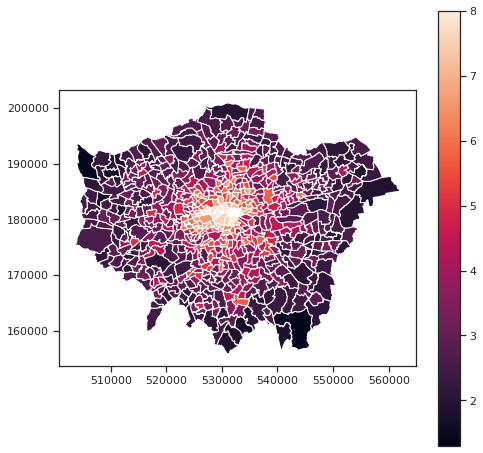

In [241]:
df_merged_2.plot(column='ptal_2013', legend=True, figsize=(8,8))

#### 5 - from pollution impact data

In [242]:
# Reading in the pollution data

file = os.path.join('data', 'raw', 'air_pollution_mortality.csv')
cols = ['Area Code', 'Area Name', 'PM2.5 Concentration (µg/m3)']

df_pollution_without_new_wards = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [243]:
# Renaming columns
df_pollution_without_new_wards.rename(columns={"Area Code": "ward_code", 
                           "Area Name": "ward_name",
                           "PM2.5 Concentration (µg/m3)": "pollution_2008"},
                  inplace=True)

df_pollution_without_new_wards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ward_code       626 non-null    object 
 1   ward_name       626 non-null    object 
 2   pollution_2008  626 non-null    float64
dtypes: float64(1), object(2)
memory usage: 14.8+ KB


In [244]:
df_pollution_without_new_wards.head(5)

,ward_code,ward_name,pollution_2008
0,C000R,Total,15.34
1,H00AA,City of London,17.59
2,00ABFX,Abbey,15.39
3,00ABFY,Alibon,14.86
4,00ABFZ,Becontree,14.94


In [245]:
# Reading in the new ward code to add new codes to pollution data

file = os.path.join('data', 'raw', 'ward-profiles-excel-version.csv')
cols = ['Old code', 'New code']

df_old_new_wards = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [246]:
# Renaming columns
df_old_new_wards.rename(columns={"Old code": "old_code", 
                           "New code": "new_code"},
                  inplace=True)

df_old_new_wards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   old_code  660 non-null    object
 1   new_code  660 non-null    object
dtypes: object(2)
memory usage: 10.4+ KB


In [247]:
df_old_new_wards.head(5)

,old_code,new_code
0,00AA,E09000001
1,00ABFX,E05000026
2,00ABFY,E05000027
3,00ABFZ,E05000028
4,00ABGA,E05000029


In [248]:
## Merge into the boundary data
df_pollution = pd.merge(df_pollution_without_new_wards, df_old_new_wards, left_on='ward_code', right_on='old_code', how='left')

# Cleaning up
df_pollution.drop(['old_code'], axis=1, inplace=True)

In [249]:
df_pollution.head(5)

,ward_code,ward_name,pollution_2008,new_code
0,C000R,Total,15.34,NaN
1,H00AA,City of London,17.59,NaN
2,00ABFX,Abbey,15.39,E05000026
3,00ABFY,Alibon,14.86,E05000027
4,00ABFZ,Becontree,14.94,E05000028


In [250]:
df_missing = df_pollution[df_pollution['pollution_2008'].isna()]
df_missing

,ward_code,ward_name,pollution_2008,new_code


In [251]:
## Merge into the boundary data
df_merged_3 = pd.merge(df_merged_2, df_pollution, left_on='GSS_CODE', right_on='new_code', how='left')

# Cleaning up
df_merged_3.drop(['ward_name', 'ward_code', 'new_code'], axis=1, inplace=True)

In [252]:
df_merged_3.tail(15)

,NAME,GSS_CODE,BOROUGH,geometry,gcse_2013,ptal_2013,nature_access_2013,population_2015,median_house_2014,median_house_2014_log,pollution_2008
634,Bread Street,E05000006,City of London,"POLYGON ((532361.400 180995.500, 532344.500 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
635,Cheap,E05000011,City of London,"POLYGON ((532038.500 181405.900, 532085.500 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
636,Bassishaw,E05000003,City of London,"POLYGON ((532207.200 181402.300, 532227.400 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,Aldersgate,E05000001,City of London,"POLYGON ((532097.100 182012.800, 532104.400 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,Dowgate,E05000016,City of London,"POLYGON ((532721.600 180518.400, 532715.000 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,Bridge,E05000007,City of London,"POLYGON ((532974.600 180959.200, 533002.200 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
640,Billingsgate,E05000004,City of London,"POLYGON ((532951.000 180492.200, 532963.400 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,Walbrook,E05000025,City of London,"POLYGON ((532942.700 181283.300, 532897.600 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
642,Cornhill,E05000014,City of London,"POLYGON ((533073.500 181460.900, 533155.100 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,Lime Street,E05000020,City of London,"POLYGON ((533149.400 181347.100, 533169.700 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
df_merged_3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   NAME                   649 non-null    object  
 1   GSS_CODE               649 non-null    object  
 2   BOROUGH                649 non-null    object  
 3   geometry               649 non-null    geometry
 4   gcse_2013              624 non-null    float64 
 5   ptal_2013              624 non-null    float64 
 6   nature_access_2013     624 non-null    float64 
 7   population_2015        624 non-null    float64 
 8   median_house_2014      624 non-null    float64 
 9   median_house_2014_log  624 non-null    float64 
 10  pollution_2008         624 non-null    float64 
dtypes: float64(7), geometry(1), object(3)
memory usage: 60.8+ KB


<AxesSubplot:>

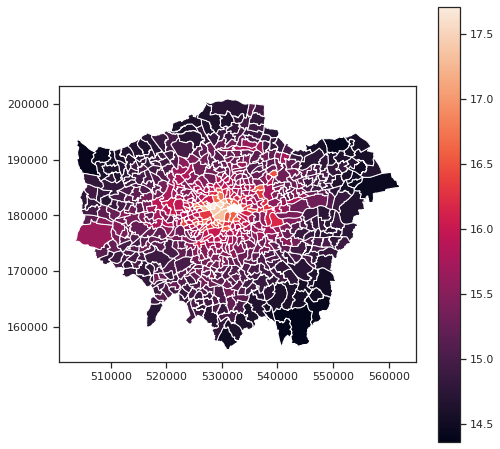

In [254]:
df_merged_3.plot(column='pollution_2008', legend=True, figsize=(8,8))

#### 6 - from crime data

In [255]:
# Reading in crime data

file = os.path.join('data', 'raw', 'MPS_Ward_Level_Crime_Historic_OldWardtoMar2010.csv')
cols = ['Ward Name', 'Ward Code', 'Minor Category', '200901', '200902', '200903', '200904',
       '200905', '200906', '200907', '200908', '200909', '200910', '200911', '200912']

df_crime = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [256]:
# Select only Domestic Burglary

df_crime = df_crime.loc[(df_crime['Minor Category'] == 'Burglary in a Dwelling')]

In [257]:
# Find the sum of Domestic Burglaries that happened in year 2014

df_crime['total2009'] = df_crime['200901'] + df_crime['200902'] + df_crime['200903'] + df_crime['200904'] + df_crime['200905'] + df_crime['200906'] + df_crime['200907'] + df_crime['200908'] + df_crime['200909'] + df_crime['200910'] + df_crime['200911'] + df_crime['200912']

In [258]:
df_crime = df_crime[['Ward Name', 'Ward Code', 'Minor Category', 'total2009']]

In [259]:
df_crime.head()

,Ward Name,Ward Code,Minor Category,total2009
1250,Abbey,E05000026,Burglary in a Dwelling,111
1251,Alibon,E05000027,Burglary in a Dwelling,91
1252,Becontree,E05000028,Burglary in a Dwelling,154
1253,Chadwell Heath,E05000029,Burglary in a Dwelling,127
1254,Eastbrook,E05000030,Burglary in a Dwelling,76


In [260]:
# Read in population data of wards

file = os.path.join('data', 'raw', 'housing-density-ward.csv')
cols = ['Code', 'Population', 'Year']

df_wardpop = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

# Filter out only year 2011
df_wardpop2011 = df_wardpop.loc[(df_wardpop['Year'] == 2011)]

In [261]:
df_wardpop2011.head()

,Code,Year,Population
0,E05000026,2011,12904
1,E05000027,2011,10468
2,E05000028,2011,11638
3,E05000029,2011,10098
4,E05000030,2011,10581


In [262]:
# do a left join - population data and crime

df_joinedcrime = pd.merge(df_crime, df_wardpop2011, left_on='Ward Code', right_on='Code', how='left')

In [263]:
# Normalise data per resident

df_joinedcrime['burglariesper1000residents'] = df_joinedcrime['total2009']/df_joinedcrime['Population']*1000

In [264]:
# Keep relevant columns

df_crimeNormalised = df_joinedcrime[['Ward Name', 'Ward Code', 'total2009', 'Population', 'burglariesper1000residents']]

In [265]:
df_crimeNormalised.head()

,Ward Name,Ward Code,total2009,Population,burglariesper1000residents
0,Abbey,E05000026,111,12904,8.601984
1,Alibon,E05000027,91,10468,8.693160
2,Becontree,E05000028,154,11638,13.232514
3,Chadwell Heath,E05000029,127,10098,12.576748
4,Eastbrook,E05000030,76,10581,7.182686


In [266]:
# Check if normalisation is accurate

df_crimeNormalised = df_crimeNormalised.sort_values(by=['burglariesper1000residents'], ascending=True)

In [267]:
df_crimeNormalised.head()

,Ward Name,Ward Code,total2009,Population,burglariesper1000residents
602,West Hill,E05000628,29,16472,1.760563
557,Millwall,E05000583,42,23383,1.796177
378,Chessington North and Hook,E05000404,19,8767,2.167218
430,Cannon Hill,E05000456,21,9307,2.256366
620,Vincent Square,E05000646,23,10003,2.299310


In [268]:
# Merge into the boundary data
df_merged_4 = pd.merge(df_merged_3, df_crimeNormalised, left_on='GSS_CODE', right_on='Ward Code', how='left')

# Cleaning up
df_merged_4.drop(['Ward Name', 'Ward Code','total2009', 'Population'], axis=1, inplace=True)

<AxesSubplot:>

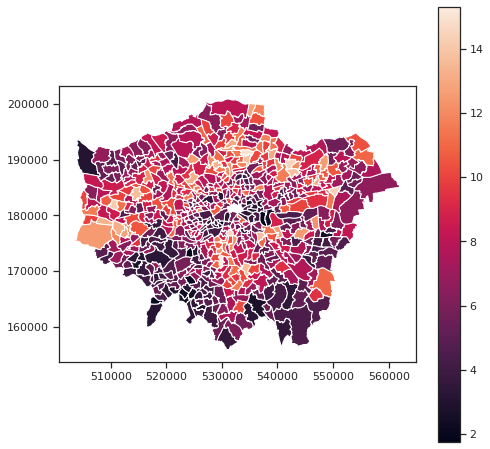

In [269]:
df_merged_4.plot(column='burglariesper1000residents', legend=True, figsize=(8,8))

In [270]:
df_merged_4.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   NAME                        649 non-null    object  
 1   GSS_CODE                    649 non-null    object  
 2   BOROUGH                     649 non-null    object  
 3   geometry                    649 non-null    geometry
 4   gcse_2013                   624 non-null    float64 
 5   ptal_2013                   624 non-null    float64 
 6   nature_access_2013          624 non-null    float64 
 7   population_2015             624 non-null    float64 
 8   median_house_2014           624 non-null    float64 
 9   median_house_2014_log       624 non-null    float64 
 10  pollution_2008              624 non-null    float64 
 11  burglariesper1000residents  624 non-null    float64 
dtypes: float64(8), geometry(1), object(3)
memory usage: 65.9+ KB


#### Finalise the dataframe and save as an output

In [271]:
# save
if not os.path.exists('data/clean'):
    os.mkdir('data/clean')

dest = os.path.join("data", "clean")
name = "df_data_pre_standardisation.csv"
file = os.path.join(dest, name)
df_merged_4.to_csv(file, index=False)

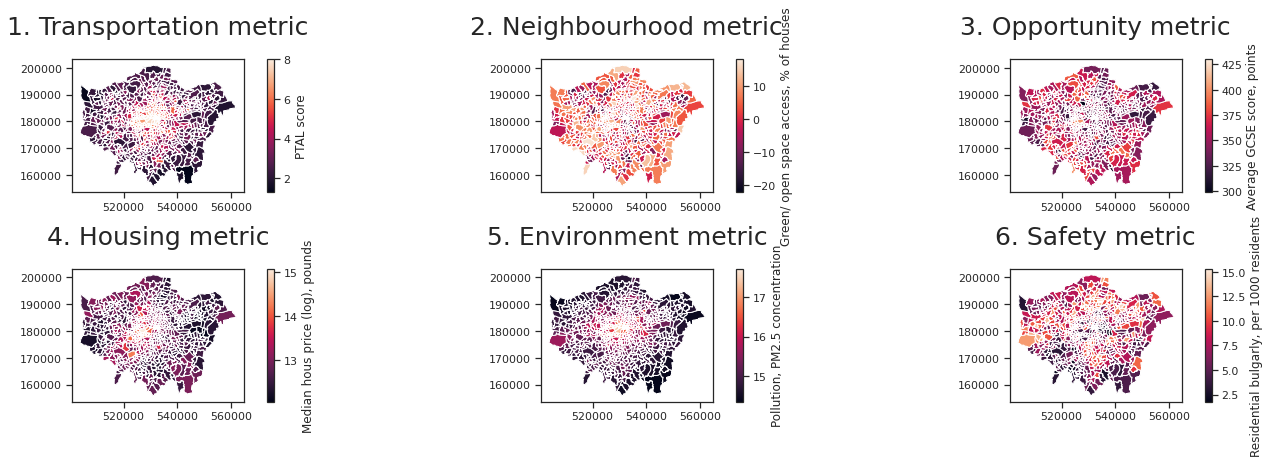

In [272]:
# Plot the distribution on histograms - code adapted from Phillip's 

cols_plot = ['ptal_2013','nature_access_2013', 'gcse_2013','median_house_2014_log', 
             'pollution_2008', 'burglariesper1000residents']

#set the histogram titles
titles = ["1. Transportation metric",
              "2. Neighbourhood metric",
              "3. Opportunity metric",
              "4. Housing metric",
              "5. Environment metric",
              "6. Safety metric"]

#set the axis labels
labels = ["PTAL score",
          "Green/ open space access, % of houses",
          "Average GCSE score, points",
          "Median hous price (log), pounds",
          "Pollution, PM2.5 concentration",
          "Residential bulgarly, per 1000 residents"]

#create a base axis for the plots
fig, ax = plt.subplots(2,3, figsize = (20,6))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(cols_plot):
    
    #add label information
    axis[i].set_title(titles[i], fontsize = 25, pad = 25)
    
    #create the plots
    df_merged_4.plot(column = col, legend = True, ax = axis[i], 
                     legend_kwds={'label': labels[i], 
                             'orientation': "vertical"})

#keep the layout tight
plt.tight_layout()
#show the plot 
plt.show()

### 3. Rescaling the data ready for clustering (Nene)

In [273]:
# Extract wards with all data existing
df_final = df_merged_4.dropna()

<AxesSubplot:>

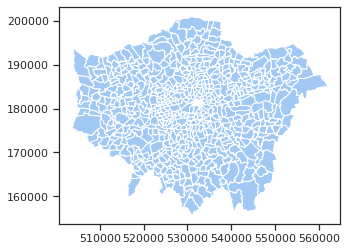

In [274]:
df_final.plot()

In [275]:
# Initialise the robust rescaler
#rbs = RobustScaler(quantile_range=[0.01,0.99])
mms = MinMaxScaler()

In [276]:
df_final.columns

Index(['NAME', 'GSS_CODE', 'BOROUGH', 'geometry', 'gcse_2013', 'ptal_2013',
       'nature_access_2013', 'population_2015', 'median_house_2014',
       'median_house_2014_log', 'pollution_2008',
       'burglariesper1000residents'],
      dtype='object')

In [277]:
### Rescale ###
to_standardise = ['gcse_2013', 'ptal_2013', 'nature_access_2013',
                  'median_house_2014_log', 'pollution_2008', 'burglariesper1000residents']

for c in to_standardise:
    df_final[c + '_mms'] = mms.fit_transform(df_final[c].values.reshape(-1,1))

# Check
df_final.head(3)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,NAME,GSS_CODE,BOROUGH,geometry,gcse_2013,ptal_2013,nature_access_2013,population_2015,median_house_2014,median_house_2014_log,pollution_2008,burglariesper1000residents,gcse_2013_mms,ptal_2013_mms,nature_access_2013_mms,median_house_2014_log_mms,pollution_2008_mms,burglariesper1000residents_mms
0,Chessington South,E05000405,Kingston upon Thames,"POLYGON ((516401.600 160201.800, 516407.300 16...",335.0,2.4,15.7,10550.0,315000.0,12.660328,14.69,3.215121,0.274809,0.164179,0.935961,0.199280,0.098507,0.107427
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,"POLYGON ((517829.600 165447.100, 517837.100 16...",336.0,2.3,-10.7,10650.0,337195.0,12.728417,15.12,4.362382,0.282443,0.149254,0.285714,0.221922,0.226866,0.192158
2,Berrylands,E05000401,Kingston upon Thames,"POLYGON ((518107.500 167303.400, 518114.300 16...",344.0,2.8,-3.0,9800.0,361125.0,12.796979,14.99,4.856932,0.343511,0.223881,0.475369,0.244721,0.188060,0.228683


In [278]:
# save
if not os.path.exists('data/clean'):
    os.mkdir('data/clean')

dest = os.path.join("data", "clean")
name = "df_data_standardised.csv"
file = os.path.join(dest, name)
df_final.to_csv(file, index=False)

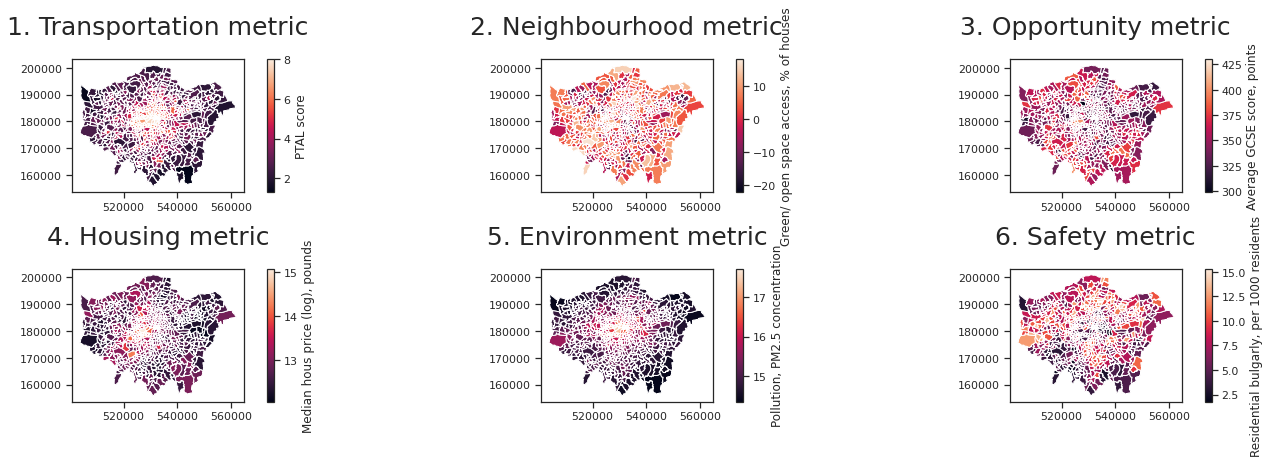

In [280]:
# Plot the distribution on histograms - code adapted from Phillip's 

cols_plot = ['ptal_2013','nature_access_2013', 'gcse_2013','median_house_2014_log', 
             'pollution_2008', 'burglariesper1000residents']

#set the histogram titles
titles = ["1. Transportation metric",
              "2. Neighbourhood metric",
              "3. Opportunity metric",
              "4. Housing metric",
              "5. Environment metric",
              "6. Safety metric"]

#set the axis labels
labels = ["PTAL score",
          "Green/ open space access, % of houses",
          "Average GCSE score, points",
          "Median hous price (log), pounds",
          "Pollution, PM2.5 concentration",
          "Residential bulgarly, per 1000 residents"]

#create a base axis for the plots
fig, ax = plt.subplots(2,3, figsize = (20,6))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(cols_plot):
    
    #add label information
    axis[i].set_title(titles[i], fontsize = 25, pad = 25)
    
    #create the plots
    df_standardised.plot(column = col, legend = True, ax = axis[i], 
                     legend_kwds={'label': labels[i], 
                             'orientation': "vertical"})

#keep the layout tight
plt.tight_layout()
#show the plot 
plt.show()

### 4. Creating statistical summary of the original data (Richy)

In [ ]:
# find the mean

print(df_final['gcse_2013'].mean())
print(df_final['ptal_2013'].mean())
print(df_final['nature_access_2013'].mean())
print(df_final['median_house_2014_log'].mean())
print(df_final['pollution_2008'].mean())
print(df_final['burglariesper1000residents'].mean())



In [ ]:
# find standard dev


print(df_final['gcse_2013'].std())
print(df_final['ptal_2013'].std())
print(df_final['nature_access_2013'].std())
print(df_final['median_house_2014_log'].std())
print(df_final['pollution_2008'].std())
print(df_final['burglariesper1000residents'].std())

In [ ]:
# print the skew

print(df_final['gcse_2013'].skew())
print(df_final['ptal_2013'].skew())
print(df_final['nature_access_2013'].skew())
print(df_final['median_house_2014_log'].skew())
print(df_final['pollution_2008'].skew())
print(df_final['burglariesper1000residents'].skew())


In [ ]:
df_final.gcse_2013.plot.hist(bins=50)

In [ ]:
df_final.ptal_2013.plot.hist(bins=50)

In [ ]:
df_final.nature_access_2013.plot.hist(bins=50)

In [ ]:
df_final.median_house_2014_log.plot.hist(bins=50)

In [ ]:
df_final.pollution_2008.plot.hist(bins=50)

In [ ]:
df_final.burglariesper1000residents.plot.hist(bins=50)

| Variable | Units | Mean | Skew | Sdv. |
| :- | :- | :-: | :-: | :-: |
| GCSE Scores | - | # | # | # |
| PTAL | Density score 0-9| # | # | # |
| Nature Access Scores | Homes with access to open space, <br> and proportion of area that is greenspace| # | # | # |
| Median House Price | £ | # | # | # |
| Air Pollution Mortality | Count | # | # | # |
| Total traffic accidents | Count | # | # | # |


### 5. Summarise statistical summary of the rescaled data (Richy)

In [ ]:
# find the mean

print(df_standardised['gcse_2013'].mean())
print(df_standardised['ptal_2013'].mean())
print(df_standardised['nature_access_2013'].mean())
print(df_standardised['median_house_2014_log'].mean())
print(df_standardised['pollution_2008'].mean())
print(df_standardised['burglariesper1000residents'].mean())

In [ ]:
# find the standard dev

print(df_standardised['gcse_2013'].std())
print(df_standardised['ptal_2013'].std())
print(df_standardised['nature_access_2013'].std())
print(df_standardised['median_house_2014_log'].std())
print(df_standardised['pollution_2008'].std())
print(df_standardised['burglariesper1000residents'].std())

In [ ]:
# find the skew

print(df_standardised['gcse_2013'].skew())
print(df_standardised['ptal_2013'].skew())
print(df_standardised['nature_access_2013'].skew())
print(df_standardised['median_house_2014_log'].skew())
print(df_standardised['pollution_2008'].skew())
print(df_standardised['burglariesper1000residents'].skew())

In [ ]:
df_standardised.gcse_2013.plot.hist(bins=50)

In [ ]:
df_standardised.ptal_2013.plot.hist(bins=50)

In [ ]:
df_standardised.nature_access_2013.plot.hist(bins=50)

In [ ]:
df_standardised.median_house_2014_log.plot.hist(bins=50)

In [ ]:
df_standardised.pollution_2008.plot.hist(bins=50)

In [ ]:
df_standardised.burglariesper1000residents.plot.hist(bins=50)

In [ ]:
df_standardised

### 6. Clustering

#### 6.1 Number of clusters

In [281]:
# variables to cluster
vars_cluster = ['gcse_2013_mms', 'ptal_2013_mms', 'nature_access_2013_mms', 'median_house_2014_log_mms', 
                'pollution_2008_mms', 'burglariesper1000residents_mms']

#### a. Elbow plot with SSE

In [282]:
#create an empty list
list_SSE = []
#set ther ange of clusters to evaluate
min_k = 1
max_k = 15
range_k = range(min_k, max_k)

#iterate over the range
for i in range_k:
    #perform the clustering algorithm
    km = KMeans(n_clusters = i,
               init = "random",
               n_init = 10,            # 10 different initialisation
               max_iter = 300,         # Max iteration for each initialised clustering
               tol = 1e-04,            
               random_state = 42)
    #fit this to the data
    km.fit(df_final[vars_cluster])
    #add the SEE score
    list_SSE.append(km.inertia_)   


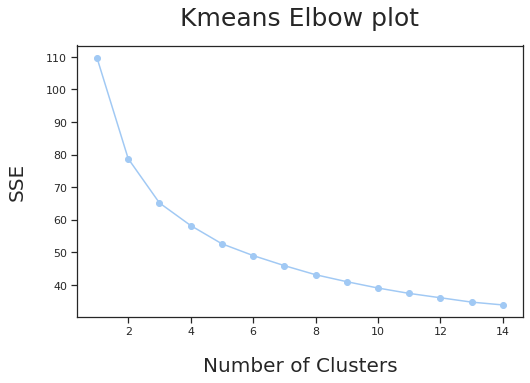

In [296]:
#create the base plots
fig, ax = plt.subplots(1,1, figsize = (8,5))

#add the data to the axis
ax.plot(range_k, list_SSE, marker = "o")

#add the necessary labels
ax.set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("SSE", fontsize =20, labelpad = 20)
ax.set_title("Kmeans Elbow plot", fontsize = 25, pad = 20)

plt.show()
os.makedirs('output plots', exist_ok=True)
fig.savefig(os.path.join('output plots','elbow.jpg'))

#### b. Silhouette plot

In [284]:
#create an empty list
silhouette = []

for i in range(2,15):
    #should ideally take the average of ~10 iterations, but due to the capacity, only conduct once
       
    #set the number of clusters
    print(i)
    k_cluster = i 
    #apply the KMeans clustering algorithm
    kmeans_method = KMeans(n_clusters = k_cluster)
    kmeans_method.fit(df_final[vars_cluster])

    #extract the labels
    labels = kmeans_method.labels_
    #extract the silhouette score
    a = metrics.silhouette_score(df_final[vars_cluster], labels)

    #append
    silhouette.append(a)

2
3
4
5
6
7
8
9
10
11
12
13
14


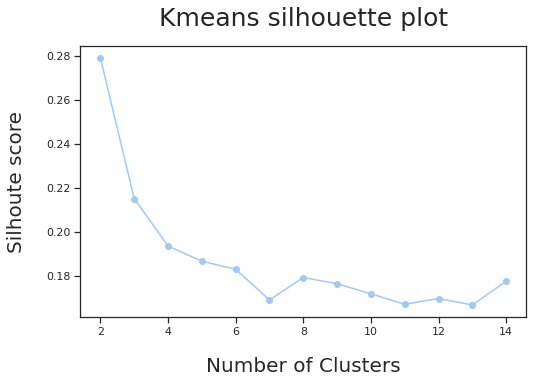

In [297]:
#create a base axis
fig, ax = plt.subplots(1,1, figsize = (8,5))

#plot the results
ax.plot(range(2,15), silhouette, marker = "o")

#add the lbels
ax.set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Silhoute score", fontsize =20, labelpad = 20)
ax.set_title("Kmeans silhouette plot", fontsize = 25, pad = 20)

plt.show()
os.makedirs('output', exist_ok=True)
fig.savefig(os.path.join('output plots','output plots'))

In [286]:
#perform the clustering with the chosen number of clusters of 2
kmeans_method = KMeans(n_clusters = 6,
                       random_state = 42,
                       n_init = 10)         # Take average of 10 iterations
kmeans_method.fit(df_final[vars_cluster])

KMeans(n_clusters=6, random_state=42)

In [287]:
#extract the cluster labels and add these back to the master data
labels = kmeans_method.labels_
df_final["labels"] = labels + 1 #adjusting the indexing to start at 1

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [288]:
# save
if not os.path.exists('data/clean'):
    os.mkdir('data/clean')

dest = os.path.join("data", "clean")
name = "df_data_clustered.csv"
file = os.path.join(dest, name)
df_final.to_csv(file, index=False)

### 7. Saving for outputs

#### 7.1 For the website
geojson for Mapbox (name, borough, geometry, percentile data for each ward, cluster labels)

In [368]:
import fiona

In [396]:
# convert to: equivalent to CRS84 (WGS84 datum, decimal degrees, and longitude and latitude units)
# https://docs.mapbox.com/help/getting-started/uploading-data/
df_final_mapbox = df_final.to_crs("EPSG:4326")
df_final_mapbox.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [397]:
df_final_mapbox.columns

Index(['NAME', 'GSS_CODE', 'BOROUGH', 'geometry', 'gcse_2013', 'ptal_2013',
       'nature_access_2013', 'population_2015', 'median_house_2014',
       'median_house_2014_log', 'pollution_2008', 'burglariesper1000residents',
       'gcse_2013_mms', 'ptal_2013_mms', 'nature_access_2013_mms',
       'median_house_2014_log_mms', 'pollution_2008_mms',
       'burglariesper1000residents_mms', 'labels'],
      dtype='object')

In [398]:
# Compute percentiles
cols = ['gcse_2013', 'ptal_2013', 'nature_access_2013', 'median_house_2014_log', 'pollution_2008', 'burglariesper1000residents']

for col in cols:
    df_final_mapbox[col + '_perc'] = df_final_mapbox[col].rank(pct = True)*100

In [399]:
df_final_mapbox.describe()

,gcse_2013,ptal_2013,nature_access_2013,population_2015,median_house_2014,median_house_2014_log,pollution_2008,burglariesper1000residents,gcse_2013_mms,ptal_2013_mms,...,median_house_2014_log_mms,pollution_2008_mms,burglariesper1000residents_mms,labels,gcse_2013_perc,ptal_2013_perc,nature_access_2013_perc,median_house_2014_log_perc,pollution_2008_perc,burglariesper1000residents_perc
count,624.000000,624.000000,624.000000,624.000000,6.240000e+02,624.000000,624.000000,624.000000,624.000000,624.000000,...,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,349.658654,3.762821,-0.206410,13822.836538,4.339210e+05,12.868973,15.338558,7.431790,0.386707,0.367585,...,0.268661,0.292107,0.418850,3.209936,50.080128,50.080128,50.080128,50.080128,50.080128,50.080128
std,17.790483,1.391211,6.799095,2901.371536,2.680934e+05,0.433284,0.551844,2.659322,0.135805,0.207644,...,0.144081,0.164729,0.196405,1.758035,28.885242,28.877778,28.890063,28.886877,28.889699,28.890635
min,299.000000,1.300000,-22.300000,5300.000000,1.730000e+05,12.061047,14.360000,1.760563,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256
25%,337.000000,2.700000,-5.000000,11650.000000,2.800000e+05,12.542545,14.937500,5.386287,0.290076,0.208955,...,0.160114,0.172388,0.267779,2.000000,24.439103,26.522436,25.080128,25.480769,25.300481,25.120192
50%,347.500000,3.400000,-0.100000,13600.000000,3.633750e+05,12.803191,15.245000,7.266668,0.370229,0.313433,...,0.246787,0.264179,0.406655,3.000000,50.000000,51.121795,50.160256,50.080128,50.040064,50.080128
75%,361.000000,4.600000,4.500000,15712.500000,4.850000e+05,13.091904,15.660000,9.148706,0.473282,0.492537,...,0.342793,0.388060,0.545654,5.000000,75.480769,74.679487,75.160256,75.080128,74.919872,75.040064
max,430.000000,8.000000,18.300000,26700.000000,3.500000e+06,15.068274,17.710000,15.300546,1.000000,1.000000,...,1.000000,1.000000,1.000000,6.000000,100.000000,99.679487,100.000000,100.000000,100.000000,100.000000


In [400]:
to_drop = ['GSS_CODE', 'gcse_2013', 'ptal_2013',
       'nature_access_2013', 'population_2015', 'median_house_2014',
       'median_house_2014_log', 'pollution_2008', 'burglariesper1000residents',
       'gcse_2013_mms', 'ptal_2013_mms', 'nature_access_2013_mms',
       'median_house_2014_log_mms', 'pollution_2008_mms',
       'burglariesper1000residents_mms']

df_final_mapbox = df_final_mapbox.drop(columns = to_drop)

In [401]:
# Bigger score = better -> Take (1-x) for Housing, Environment, and Crime rate
df_final_mapbox['median_house_2014_log_perc'] = 100-df_final_mapbox['median_house_2014_log_perc']
df_final_mapbox['pollution_2008_perc'] = 100-df_final_mapbox['pollution_2008_perc']
df_final_mapbox['burglariesper1000residents_perc'] = 100-df_final_mapbox['burglariesper1000residents_perc']

In [402]:
df_final_mapbox.describe()

,labels,gcse_2013_perc,ptal_2013_perc,nature_access_2013_perc,median_house_2014_log_perc,pollution_2008_perc,burglariesper1000residents_perc
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,3.209936,50.080128,50.080128,50.080128,49.919872,49.919872,49.919872
std,1.758035,28.885242,28.877778,28.890063,28.886877,28.889699,28.890635
min,1.000000,0.160256,0.160256,0.160256,0.000000,0.000000,0.000000
25%,2.000000,24.439103,26.522436,25.080128,24.919872,25.080128,24.959936
50%,3.000000,50.000000,51.121795,50.160256,49.919872,49.959936,49.919872
75%,5.000000,75.480769,74.679487,75.160256,74.519231,74.699519,74.879808
max,6.000000,100.000000,99.679487,100.000000,99.839744,99.839744,99.839744


In [404]:
# save
dest = os.path.join("data", "shape")
os.makedirs(dest, exist_ok=True)
name = "london_ward_clusters.geojson"
file = os.path.join(dest, name)
df_final_mapbox.to_file(file, driver='GeoJSON')

### 7. Cluster profiling
vars_cluster = ['gcse_2013', 'ptal_2013', 'nature_access_2013', 'median_house_2014_log', 
                'pollution_2008', 'burglariesper1000residents']

<Figure size 432x288 with 0 Axes>

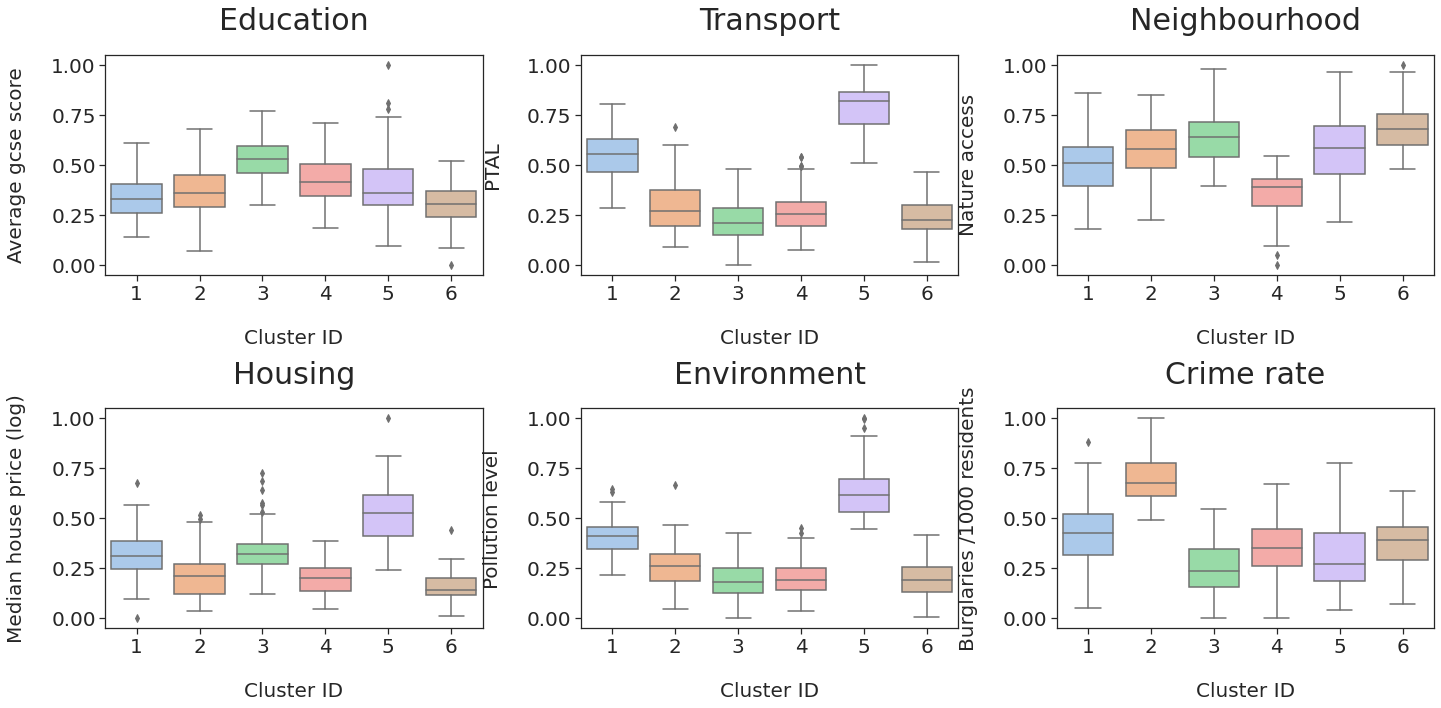

In [298]:
#creating boxplots to umderstand the cluster characteristics

#set the titles and labels
titles = ['Education', 'Transport', 'Neighbourhood', 'Housing','Environment', 'Crime rate']
ylabels = ["Average gcse score", "PTAL", "Nature access", "Median house price (log)",
           "Pollution level", "Burglaries /1000 residents"]

#create a base plot with seaborn
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
sns.despine(offset = 10) 
fig, ax = plt.subplots(2,3, figsize = (20,10))
axis = ax.flatten()

#iterate over each column to create (6 variables x 4 clusters) of boxplots
for i, col in enumerate(vars_cluster):

    sns.boxplot(y=df_final[col], x=df_final['labels'], ax=axis[i])   # Plotting   
    #set the plots up
    axis[i].set_title(titles[i], fontsize = 30, pad = 25)
    axis[i].set_xlabel("Cluster ID", fontsize = 20, labelpad = 25)
    #axis[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axis[i].set_ylabel(ylabels[i], fontsize =20, labelpad = 25)
    axis[i].tick_params(axis = "both", labelsize = 20)

#set the layout to tight so no overalp
plt.tight_layout()

# Save
os.makedirs('output plots', exist_ok=True)
fig.savefig(os.path.join('output plots','component_box.jpg'))

In [292]:
df_final.describe()

,gcse_2013,ptal_2013,nature_access_2013,population_2015,median_house_2014,median_house_2014_log,pollution_2008,burglariesper1000residents,gcse_2013_mms,ptal_2013_mms,nature_access_2013_mms,median_house_2014_log_mms,pollution_2008_mms,burglariesper1000residents_mms,labels
count,624.000000,624.000000,624.000000,624.000000,6.240000e+02,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,349.658654,3.762821,-0.206410,13822.836538,4.339210e+05,12.868973,15.338558,7.431790,0.386707,0.367585,0.544177,0.268661,0.292107,0.418850,3.209936
std,17.790483,1.391211,6.799095,2901.371536,2.680934e+05,0.433284,0.551844,2.659322,0.135805,0.207644,0.167465,0.144081,0.164729,0.196405,1.758035
min,299.000000,1.300000,-22.300000,5300.000000,1.730000e+05,12.061047,14.360000,1.760563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,337.000000,2.700000,-5.000000,11650.000000,2.800000e+05,12.542545,14.937500,5.386287,0.290076,0.208955,0.426108,0.160114,0.172388,0.267779,2.000000
50%,347.500000,3.400000,-0.100000,13600.000000,3.633750e+05,12.803191,15.245000,7.266668,0.370229,0.313433,0.546798,0.246787,0.264179,0.406655,3.000000
75%,361.000000,4.600000,4.500000,15712.500000,4.850000e+05,13.091904,15.660000,9.148706,0.473282,0.492537,0.660099,0.342793,0.388060,0.545654,5.000000
max,430.000000,8.000000,18.300000,26700.000000,3.500000e+06,15.068274,17.710000,15.300546,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


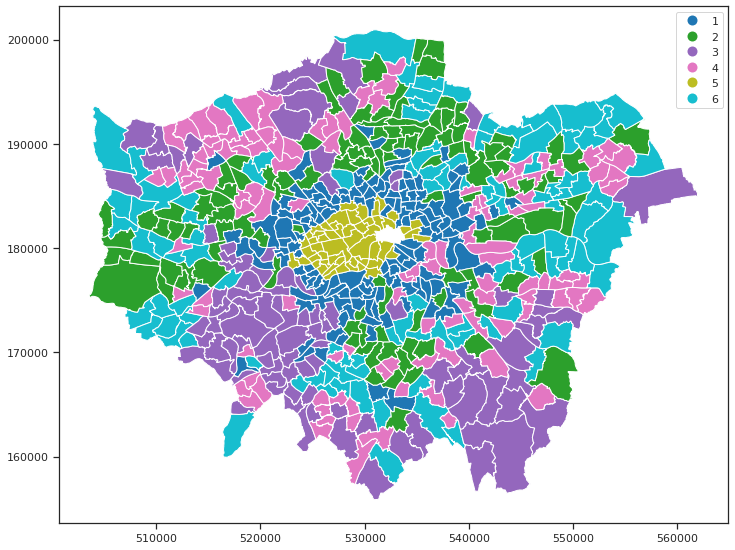

In [299]:
fig, ax = plt.subplots(1, figsize=(12,10))
df_final.plot(column='labels', categorical=True, ax=ax, legend=True)

# Save
os.makedirs('output plots', exist_ok=True)
fig.savefig(os.path.join('output plots','clustered map.jpg'))

In [300]:
df_final_pd = pd.DataFrame(df_final)

In [309]:
df_final_pd.drop(['gcse_2013', 'ptal_2013', 'nature_access_2013', 'population_2015', 'median_house_2014',
                 'median_house_2014_log', 'pollution_2008', 'burglariesper1000residents'], 
                 axis=1, inplace=True)

In [310]:
summary = df_final_pd.groupby(['labels']).median()
summary

,gcse_2013_mms,ptal_2013_mms,nature_access_2013_mms,median_house_2014_log_mms,pollution_2008_mms,burglariesper1000residents_mms
labels,,,,,,
1,0.328244,0.552239,0.509852,0.313895,0.408955,0.426272
2,0.358779,0.268657,0.578818,0.209673,0.259701,0.677966
3,0.526718,0.208955,0.640394,0.321561,0.179104,0.234760
4,0.412214,0.253731,0.387931,0.199280,0.191045,0.349175
5,0.358779,0.820896,0.581281,0.525438,0.614925,0.273235
6,0.305344,0.223881,0.677340,0.141018,0.189552,0.391351


In [314]:
summary.rename(columns={'gcse_2013_mms': 'Education', 
                           'ptal_2013_mms': 'Transport',
                           "nature_access_2013_mms": "Nature access",
                           "median_house_2014_log_mms": "Housing",
                           'pollution_2008_mms': 'Environment',
                           'burglariesper1000residents_mms': 'Crime rate'},
                  inplace=True)

In [317]:
# Bigger score = better -> Take (1-x) for Housing, Environment, and Crime rate
summary['Housing'] = 1-summary['Housing']
summary['Environment'] = 1-summary['Environment']
summary['Crime rate'] = 1-summary['Crime rate']

In [337]:
summary

,Education,Transport,Nature access,Housing,Environment,Crime rate
labels,,,,,,
1,0.328244,0.552239,0.509852,0.686105,0.591045,0.573728
2,0.358779,0.268657,0.578818,0.790327,0.740299,0.322034
3,0.526718,0.208955,0.640394,0.678439,0.820896,0.765240
4,0.412214,0.253731,0.387931,0.800720,0.808955,0.650825
5,0.358779,0.820896,0.581281,0.474562,0.385075,0.726765
6,0.305344,0.223881,0.677340,0.858982,0.810448,0.608649


In [341]:
#summary.columns
cols = ['Education', 'Transport', 'Nature access', 'Housing', 'Environment', 'Crime rate']

In [346]:
# Standardise within medians
mms = MinMaxScaler()
summary_heat = pd.DataFrame()

for c in cols:
    summary_heat[c] = summary[c]/summary[c].min()

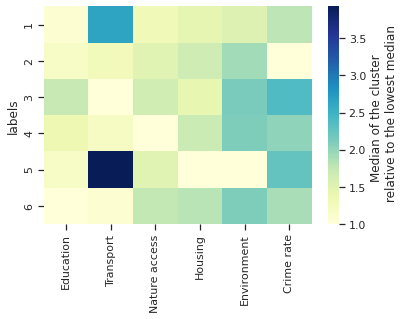

In [358]:
heatmap = sns.heatmap(summary_heat, cmap="YlGnBu", cbar_kws={'label': 'Median of the cluster \n relative to the lowest median'})
fig = heatmap.get_figure()

# Save
os.makedirs('output plots', exist_ok=True)
fig.savefig(os.path.join('output plots','heatmap.jpg'))